In [100]:
import TensorFrost as tf
import numpy as np
import matplotlib.pyplot as plt
import time

tf.initialize(tf.cpu)

S = 1024
MAX_ITER = 1000
SAMPLES = 64

T1 = MAX_ITER // 50
T2 = MAX_ITER // 10
T3 = MAX_ITER

def smoothstep(edge0, edge1, x):
    t = tf.clamp((x - edge0) / (edge1 - edge0), 0.0, 1.0)
    return t * t * (3.0 - 2.0 * t)

def mandelbrot():
    atomic_canvas = tf.zeros([S, S, 3], tf.int32)
    i, j = tf.indices([S, S])
    x, y = tf.float(i), tf.float(j)
    seed = tf.uint(i + j * S)
    aspect = tf.float(S) / tf.float(S)

    def sample_iteration(sit):
        seed.set(tf.pcg(seed))
        u = (x + 2.0*tf.pcgf(seed)) / tf.float(S)
        v = (y + 2.0*tf.pcgf(seed + tf.uint(5))) / tf.float(S)
        u0 = (x + 2.0*tf.pcgf(seed + tf.uint(25))) / tf.float(S)
        v0 = (y + 2.0*tf.pcgf(seed + tf.uint(388))) / tf.float(S)

        cx = (u * 2.0 - 1.0) * aspect * 1.5
        cy = (v * 2.0 - 1.0) * aspect * 1.5
        z0x = (u0 * 2.0 - 1.0) * aspect * 1.5
        z0y = (v0 * 2.0 - 1.0) * aspect * 1.5

        z_re = z0x + 1e-6 #making a botched copy of the variable to avoid a bug
        z_im = z0y + 1e-6
        l = tf.zeros([], tf.int32)
        c_re = cx
        c_im = cy

        def loop_body(k):
            z_re_new = z_re*z_re - z_im*z_im + c_re
            z_im_new = 2.0*z_re*z_im + c_im
            z_re.set(z_re_new)
            z_im.set(z_im_new)
            tf.if_cond((z_re*z_re + z_im*z_im) > 4.0, lambda: tf.break_loop())
            l.set(l + 1)

        tf.loop(loop_body, 0, MAX_ITER, 1)

        tf.if_cond(l >= MAX_ITER, lambda: tf.continue_loop())

        z_re.set(z0x)
        z_im.set(z0y)

        def loop_body(k):
            z_re_new = z_re*z_re - z_im*z_im + c_re
            z_im_new = 2.0*z_re*z_im + c_im
            z_re.set(z_re_new)
            z_im.set(z_im_new)
            tf.if_cond((z_re*z_re + z_im*z_im) > 4.0, lambda: tf.break_loop())
            px = z_re / 1.5 / aspect * 0.5 + 0.6
            py = z_im / 1.5 / aspect * 0.5 + 0.5
            tf.if_cond((px < 0.0) | (px > 1.0) | (py < 0.0) | (py > 1.0), lambda: tf.continue_loop())
            x_pix = tf.int(px * tf.float(S))
            y_pix = tf.int(py * tf.float(S))
    
            ch = tf.select(l < T1, 2, tf.select(l < T2, 1, 0))
            tf.scatterAdd(atomic_canvas[S - 1 - y_pix, x_pix, ch], 1)
            tf.scatterAdd(atomic_canvas[y_pix, x_pix, ch], 1)

        tf.loop(loop_body, 0, MAX_ITER, 1)

    tf.loop(sample_iteration, 0, SAMPLES, 1)

    canvas = tf.buffer([S, S, 3], tf.float32)

    x = tf.float(atomic_canvas[i, j, 0])
    y = tf.float(atomic_canvas[i, j, 1])
    z = tf.float(atomic_canvas[i, j, 2])
    rx = x + y + z
    ry = y + z
    rz = z

    norm = float(MAX_ITER * SAMPLES) / 15.0

    canvas[i, j, 0] = smoothstep(0.0, 1.0, 2.5 * (rx/norm) ** 0.9)
    canvas[i, j, 1] = smoothstep(0.0, 1.0, 2.5 * (ry/norm) ** 0.8)
    canvas[i, j, 2] = smoothstep(0.0, 1.0, 2.5 * (rz/norm) ** 0.7)

    return [canvas]

mand = tf.compile(mandelbrot)

mandelbrot:
  Kernel count: 3
  Intermediate buffers: 1
  Lines of generated code: 533



In [101]:
res = mand()
resnp = res[0].numpy
print(resnp.shape)

(1024, 1024, 3)


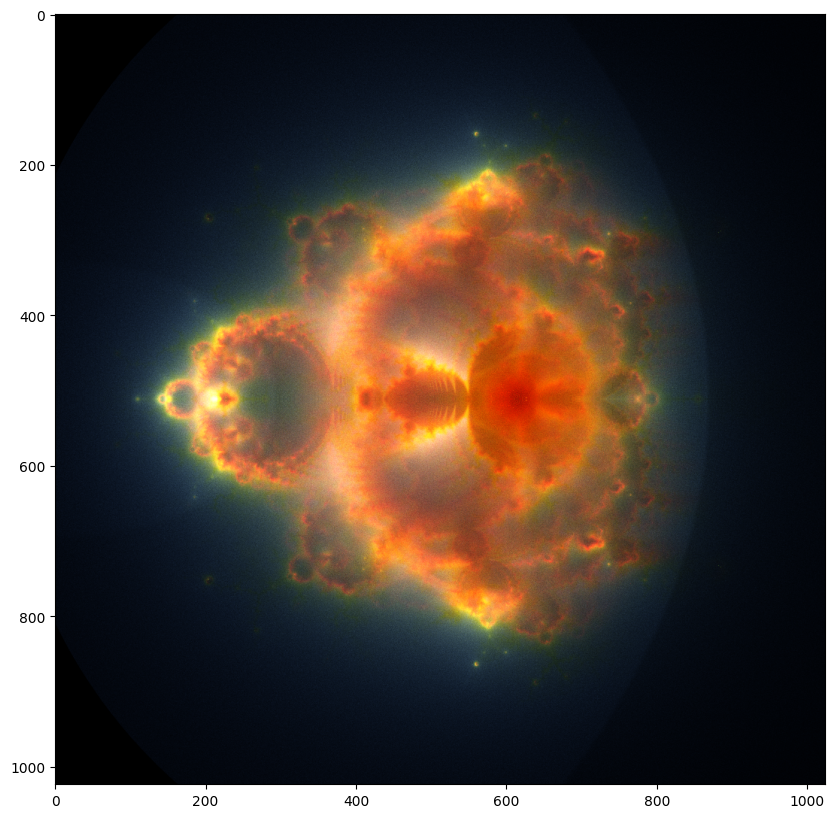

In [102]:
# plot the result
plt.figure(figsize=(10,10))
plt.imshow(resnp)
plt.show()